# **Deep Models**

**LSTM Model**  

In this notebook, we test Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN) specifically designed to handle sequential data. LSTMs are well-suited for time-series problems as they can capture long-term dependencies and patterns in sequential data, overcoming the vanishing gradient problem that traditional RNNs face.  

LSTMs achieve this by using a specialized memory cell structure with input, output, and forget gates, allowing the network to selectively retain and discard information over time. This makes them particularly effective for capturing trends, seasonality, and temporal relationships in our dataset. Given the sequential nature of our data, LSTMs provide a deep learning-based approach that complements our baseline XGBoost model, enabling us to explore potential improvements in predictive performance. 

In this LSTM (Long Short-Term Memory) implementation, several key techniques and "tricks" are used to improve model performance and learning:

1. Sequence Creation Trick
The `prepare_sequence_data()` function uses a sliding window approach to create sequences:
- Transforms flat data into temporal sequences
- Captures historical context by creating input sequences of fixed length
- Allows the model to learn from previous time steps

2. Time Series Cross-Validation Approach
- Maintains chronological order during data splitting
- Uses `shuffle=False` to preserve temporal dependencies
- Ensures that training respects the time-based nature of the data

3. LSTM Architecture Tricks
- Multiple LSTM Layers (num_layers=2)
  * Allows learning of more complex temporal representations
  * Increases model capacity to capture intricate patterns

- Dropout in LSTM
  * Prevents overfitting
  * Helps model generalize better by randomly dropping connections

4. Hidden State Initialization
```python
h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
```
- Explicitly initializes hidden and cell states
- Ensures clean slate for each sequence processing
- Moves initialization to the same device as input (GPU/CPU)

5. Last Timestep Selection
```python
out = self.fc(out[:, -1, :])
```
- Uses only the last timestep for prediction
- Captures the most recent temporal context
- Allows final layer to make prediction based on entire sequence

6. Adaptive Learning Techniques
- Adam Optimizer
  * Adaptive learning rates for each parameter
  * Handles different scales of parameters effectively

- Early stopping concept (implicitly through epoch-based training)
  * Prevents overfitting by monitoring train/test losses

7. Device Agnostic Training
```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```
- Automatically uses GPU if available
- Falls back to CPU seamlessly

8. Loss and Metrics Tracking
- Captures both training and validation losses
- Enables detailed performance analysis
- Helps diagnose potential overfitting

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import time

In [21]:
PROCESSED_PATH = Path("data/processed")
MODELS_PATH = Path("models")
RESULTS_PATH = Path("results")

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [22]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
class TrainDelayLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(TrainDelayLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.apply(init_weights)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def prepare_sequence_data(df, target_col, sequence_length=5):
    df = df.sort_values(by=['month', 'day_of_week', 'hour'])
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    sequences = np.array([X_scaled[i:i+sequence_length] for i in range(len(X_scaled) - sequence_length)])
    targets = np.array(y.iloc[sequence_length:])
    
    return torch.FloatTensor(sequences), torch.FloatTensor(targets), scaler

In [ ]:
def train_lstm_model(dataset_name, sequence_length=5):
    df = pd.read_parquet(PROCESSED_PATH / f"final_data{'_graph' if dataset_name == 'Graph' else ''}.parquet")
    X_seq, y_seq, scaler = prepare_sequence_data(df, 'stop_arrival_delay', sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device}")
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
    
    input_size = X_train.shape[2]
    model = TrainDelayLSTM(input_size=input_size, hidden_size=64, num_layers=2, output_size=1).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    scaler = GradScaler()
    
    num_epochs = 50
    train_losses, test_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
            
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
        scheduler.step()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.numpy())
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    
    print(f"{dataset_name} LSTM Results: MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    torch.save(model.state_dict(), MODELS_PATH / f"lstm_{dataset_name.lower()}.pth")
    
    results_df = pd.DataFrame({
        'Dataset': [dataset_name],
        'MAE': [mae],
        'RMSE': [rmse],
        'R²': [r2]
    })
    results_df.to_csv(RESULTS_PATH / f"lstm_results_{dataset_name.lower()}.csv", index=False)
    
    return model

In [8]:
datasets = ['Base', 'Graph']

for dataset in datasets:
    train_lstm_model(dataset)

Training on cuda


C:\Users\Ningo\AppData\Local\Temp\ipykernel_30576\3477508518.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50, Train Loss: 7.5206, Test Loss: 7.2234
Epoch 11/50, Train Loss: 6.1366, Test Loss: 7.0710
Epoch 21/50, Train Loss: 5.9853, Test Loss: 7.0898
Epoch 31/50, Train Loss: 5.8029, Test Loss: 7.3709
Epoch 41/50, Train Loss: 5.7511, Test Loss: 7.3962
Base LSTM Results: MAE: 1.4044, RMSE: 2.7505, R²: 0.8841
Training on cuda


C:\Users\Ningo\AppData\Local\Temp\ipykernel_30576\3477508518.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50, Train Loss: 7.2703, Test Loss: 6.8586
Epoch 11/50, Train Loss: 5.8482, Test Loss: 7.2969
Epoch 21/50, Train Loss: 5.7264, Test Loss: 7.8746
Epoch 31/50, Train Loss: 5.5576, Test Loss: 7.6156
Epoch 41/50, Train Loss: 5.5001, Test Loss: 7.8699
Graph LSTM Results: MAE: 1.3823, RMSE: 2.7842, R²: 0.8810


### **Results Analysis**

The LSTM model was trained and evaluated on two datasets: one containing only the base features and another enriched with graph-based features. The results show that the model trained on the graph-enhanced dataset achieved a slightly lower Mean Absolute Error (MAE), indicating better performance in predicting small and frequent delays. Specifically, the MAE decreased from *1.4044* to *1.3823*.

However, the Root Mean Squared Error (RMSE) increased slightly from *2.7505* to *2.7842*, and the R^2 score dropped from *0.8841* to *0.8810*. This suggests that while the graph features helped reduce average prediction errors, they may have introduced additional complexity or noise, leading to larger errors in some cases and slightly worse overall variance explained.

---
---
---

## **Graph Embedding**

In [ ]:
import networkx as nx
from node2vec import Node2Vec
import pandas as pd

In [2]:
graph_path = "other/train_network.graphml"
G = nx.read_graphml(graph_path)

In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [4]:
station_embeddings = pd.DataFrame(
    [model.wv[key] for key in model.wv.key_to_index], 
    index=model.wv.key_to_index
).reset_index().rename(columns={"index": "station_name"})

In [5]:
embedding_path = "other/station_embeddings.csv"
station_embeddings.to_csv(embedding_path, index=False)

print(f"Embedding salvati in {embedding_path}")

Embedding salvati in other/station_embeddings.csv


## **Unire l'embedding al dataset**

**Unire l'embedding del grafo al dataset e usarlo in un LSTM: ha senso?**
**Dipende dallo scopo e da come intendi farlo.**
Se vuoi unire l’embedding alle sequenze temporali e dare tutto in pasto a un LSTM, bisogna capire cosa rappresentano quegli embedding:

L'embedding che hai calcolato rappresenta una **caratteristica stazionaria della rete** → Non cambia nel tempo.  
In pratica, ogni stazione ha un vettore di embedding fisso che descrive la sua **posizione topologica** nella rete.

Quando tu hai sequenze temporali tipo:
```
Giorno, Ora, Ritardo, ...
```
e gli aggiungi un embedding **fisso** come feature, stai dicendo al modello:
> Oltre alle informazioni temporali, ti do anche informazioni strutturali sul nodo (stazione) coinvolto.

**Quando questa scelta funziona bene**
Se nei tuoi dati esiste una relazione **forte tra ritardi e posizione nella rete ferroviaria** (ad esempio: i ritardi si accumulano in stazioni centrali o di snodo), allora unire gli embedding ai dati temporali può aiutare.  
L’LSTM potrà imparare che alcune stazioni tendono a causare ritardi cronici o sono colli di bottiglia.

**Quando ha poco senso**
Se il target che stai cercando di predire riguarda solo **ritardi a livello di singolo treno e dipende più da orari, condizioni e meno dalla topologia**, allora quell'embedding potrebbe non aggiungere molto e rischi di complicare inutilmente il modello.

Dal momento che ci serve la colonna stop_name per effettuare il merge con l'embedding, carichiamo il dataset non finale e ci lavoriamo

Alleniamo la stessa LSTM di prima

Integrazione degli embedding strutturali nella rete LSTM
Abbiamo esteso l’input dei nostri modelli sequenziali includendo embedding strutturali ottenuti tramite Node2Vec sul grafo ferroviario. Tali embedding rappresentano informazioni latenti sulla posizione topologica di ogni stazione nella rete.
L’inclusione di queste informazioni consente alla rete LSTM di apprendere non solo le dinamiche temporali, ma anche le potenziali influenze strutturali legate alla posizione della stazione nella rete.
Per evitare un aumento eccessivo della dimensionalità in input, è stato inoltre introdotto un livello di proiezione lineare che riduce la dimensionalità prima dell’input all’LSTM, migliorando l’efficienza computazionale e riducendo il rischio di overfitting.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
PROCESSED_PATH = Path("data/processed")
OTHER_PATH = Path("other")
MODELS_PATH = Path("models")
RESULTS_PATH = Path("results")

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [23]:
df = pd.read_parquet(PROCESSED_PATH / "train_data_fe.parquet")
embedding = pd.read_csv(OTHER_PATH / "station_embeddings.csv")

In [24]:
df = df.merge(embedding, left_on="stop_name", right_on="station_name", how="left")
df.drop(columns=["station_name"], inplace=True)

In [25]:
drop_cols = [
    "scheduled_departure_time", 
    "scheduled_arrival_time",
    "stop_departure_time",
    "departure_station", "arrival_station",
    "stop_name"
]
df.drop(columns=drop_cols, inplace=True)

In [26]:
df["train_avg_delay"] = df.groupby("train_number")["stop_arrival_delay"].transform("mean")
df.drop(columns=["train_number"], inplace=True)
df.dropna(inplace=True)

In [27]:
embedding_cols = [col for col in df.columns if col.startswith('0') or col.isdigit()]

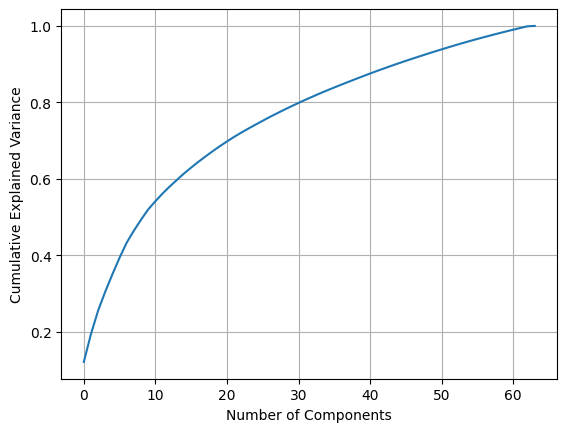

In [28]:
pca_full = PCA(n_components=64)
pca_full.fit(df[embedding_cols])

plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [ ]:
pca = PCA(n_components=10)
embedding_pca = pca.fit_transform(df[embedding_cols])

In [9]:
pca_cols = [f"embed_pca_{i}" for i in range(embedding_pca.shape[1])]
df[pca_cols] = embedding_pca
df.drop(columns=embedding_cols, inplace=True)

In [10]:
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2f}")

PCA explained variance: 0.52


**PCA sugli embedding del grafo**

Per ridurre la dimensionalità degli embedding Node2Vec ottenuti dalla rete ferroviaria, abbiamo applicato la tecnica della Principal Component Analysis (PCA). L'obiettivo di questa riduzione è duplice: da un lato, eliminare ridondanze e rumore presenti nelle 64 dimensioni originarie; dall'altro, rendere il modello LSTM più efficiente in termini di tempo di training e inferenza, senza compromettere eccessivamente le informazioni rilevanti.

Dopo aver applicato la PCA, abbiamo scelto di mantenere le prime 10 componenti principali, che spiegano complessivamente circa il 52% della varianza totale. Questo valore indica che oltre la metà dell'informazione contenuta negli embedding originali viene preservata nelle nuove feature. Sebbene non rappresenti la totalità della varianza, si tratta di un compromesso consapevole tra informazione e efficienza computazionale. Inoltre, abbiamo verificato che l’aggiunta di ulteriori componenti oltre le prime dieci avrebbe incrementato marginalmente la varianza spiegata, a fronte di un costo computazionale più elevato e un rischio maggiore di overfitting.

Infine, la scelta di applicare la PCA è stata guidata anche dal contesto del problema: essendo gli embedding Node2Vec basati sulla struttura topologica del grafo, parte dell’informazione geometrica e relazionale è ridondante rispetto alle feature già presenti nel dataset, rendendo la compressione tramite PCA una soluzione efficace.

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [12]:
class TrainDelayLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(TrainDelayLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.apply(init_weights)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
def prepare_sequence_data(df, target_col, sequence_length=5):
    df = df.sort_values(by=['month', 'day_of_week', 'hour'])
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    sequences = np.array([X_scaled[i:i+sequence_length] for i in range(len(X_scaled) - sequence_length)])
    targets = np.array(y.iloc[sequence_length:])
    return torch.FloatTensor(sequences), torch.FloatTensor(targets), scaler

In [18]:
def train_lstm_embedding(sequence_length=5):
    X_seq, y_seq, scaler = prepare_sequence_data(df, 'stop_arrival_delay', sequence_length)
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device}")

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

    input_size = X_train.shape[2]
    model = TrainDelayLSTM(input_size=input_size, hidden_size=64, num_layers=2, output_size=1).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    scaler_amp = GradScaler()

    num_epochs = 50
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
            scaler_amp.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler_amp.step(optimizer)
            scaler_amp.update()
            train_loss += loss.item()
        scheduler.step()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    # Evaluation
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.numpy())

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    print(f"\nLSTM + Graph Embedding Results: MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    torch.save(model.state_dict(), MODELS_PATH / "lstm_graph_embedding.pth")
    pd.DataFrame({
        'MAE': [mae],
        'RMSE': [rmse],
        'R²': [r2]
    }).to_csv(RESULTS_PATH / "lstm_results_graph_embedding.csv", index=False)

    return model


In [19]:
train_lstm_embedding(sequence_length=5)

Training on cuda
Epoch 1/50, Train Loss: 7.0670, Test Loss: 6.6708
Epoch 11/50, Train Loss: 5.8065, Test Loss: 7.0272
Epoch 21/50, Train Loss: 5.6950, Test Loss: 6.8323
Epoch 31/50, Train Loss: 5.5213, Test Loss: 6.8007
Epoch 41/50, Train Loss: 5.4656, Test Loss: 6.9126

LSTM + Graph Embedding Results: MAE: 1.3548, RMSE: 2.6320, R²: 0.8938


TrainDelayLSTM(
  (lstm): LSTM(28, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)